In [10]:
%matplotlib inline
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/Montage/bin

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/Montage/bin


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import theano
import theano.tensor as T

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.objectives import squared_error
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

from astropy.io import fits
from astropy import wcs

In [ ]:
X_ex = np.load("../data/X_train.npz")
namelist = X_ex.zip.namelist()
X_ex.zip.extract(namelist[0])
X_train = np.load(namelist[0], mmap_mode='r+')

In [ ]:
X_ex = np.load("../data/X_test.npz")
namelist = X_ex.zip.namelist()
X_ex.zip.extract(namelist[0])
X_test = np.load(namelist[0], mmap_mode='r+')

In [5]:
y_test = np.load("../data/y_test.npy")
y_train = np.load("../data/y_train.npy")

In [6]:
print(y)

[[ 0.1104974]
 [ 0.4793113]
 [ 0.1628425]
 ..., 
 [ 0.5312797]
 [ 0.4740712]
 [ 0.1174097]]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

MemoryError: 

In [7]:
print("X_train.shape = {}, X.min = {}, X.max = {}".format(X_train.shape, X_train.min(), X_train.max()))
print("y_train.shape = {}, y.min = {}, y.max = {}".format(y_train.shape, y_train.min(), y_train.max()))
print(type(y_test))
print(type(X))

MemoryError: 

In [7]:
def renormalize(array):
    return (array - array.min()) / (array.max() - array.min())

for i in range(5):
    X_train[:, i, :, :] = renormalize(X_train[:, i, :, :])
    
y_train = renormalize(y_train)     #maybe this shouldn't be renormalized, since we need to have this be the true value?
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)
print("X.shape = {}, X.min = {}, X.max = {}".format(X_train.shape, X_train.min(), X_train.max()))
print("y.shape = {}, y.min = {}, y.max = {}".format(y_train.shape, y_train.min(), y_train.max()))

X.shape = (185, 5, 48, 48), X.min = 0.0, X.max = 1.0
y.shape = (185, 1), y.min = 0.0, y.max = 1.0


In [8]:
def compute_PCA(array):

    nimages0, nchannels0, height0, width0 = array.shape
    rolled = np.transpose(array, (0, 2, 3, 1))
    # transpose from N x channels x height x width  to  N x height x width x channels
    nimages1, height1, width1, nchannels1 = rolled.shape
    # check shapes
    assert nimages0 == nimages1
    assert nchannels0 == nchannels1
    assert height0 == height1
    assert width0 == width1
    # flatten
    reshaped = rolled.reshape(nimages1 * height1 * width1, nchannels1)
    
    from sklearn.decomposition import PCA
    
    pca = PCA()
    pca.fit(reshaped)
    
    cov = pca.get_covariance()
    
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    return eigenvalues, eigenvectors

In [9]:
class AugmentedBatchIterator(BatchIterator):
    
    def __init__(self, batch_size, crop_size=8, testing=False):
        super(AugmentedBatchIterator, self).__init__(batch_size)
        self.crop_size = crop_size
        self.testing = testing

    def transform(self, Xb, yb):

        Xb, yb = super(AugmentedBatchIterator, self).transform(Xb, yb)
        batch_size, nchannels, width, height = Xb.shape
        
        if self.testing:
            if self.crop_size % 2 == 0:
                right = left = self.crop_size // 2
            else:
                right = self.crop_size // 2
                left = self.crop_size // 2 + 1
            X_new = Xb[:, :, right: -left, right: -left]
            return X_new, yb

        eigenvalues, eigenvectors = compute_PCA(Xb)

        # Flip half of the images horizontally at random
        indices = np.random.choice(batch_size, batch_size // 2, replace=False)        
        Xb[indices] = Xb[indices, :, :, ::-1]

        # Crop images
        X_new = np.zeros(
            (batch_size, nchannels, width - self.crop_size, height - self.crop_size),
            dtype=np.float32
        )

        for i in range(batch_size):
            # Choose x, y pixel posiitions at random
            px, py = np.random.choice(self.crop_size, size=2)
                
            sx = slice(px, px + width - self.crop_size)
            sy = slice(py, py + height - self.crop_size)
            
            # Rotate 0, 90, 180, or 270 degrees at random
            nrotate = np.random.choice(4)
            
            # add random color perturbation
            alpha = np.random.normal(loc=0.0, scale=0.5, size=5)
            noise = np.dot(eigenvectors, np.transpose(alpha * eigenvalues))
            
            for j in range(nchannels):
                X_new[i, j] = np.rot90(Xb[i, j, sx, sy] + noise[j], k=nrotate)
                
        return X_new, yb

In [10]:
class SaveParams(object):
    def __init__(self, name):
        self.name = name

    def __call__(self, nn, train_history):
        if train_history[-1]["valid_loss_best"]:
            nn.save_params_to("{}.params".format(self.name))
            with open("{}.history".format(self.name), "wb") as f:
                pickle.dump(train_history, f)

We set the `verbose` parameter to `2`.

# 4 dropout layer

In [11]:
net49 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),

        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),

        ('conv21', layers.Conv2DLayer),
        ('conv22', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),

        ('conv31', layers.Conv2DLayer),
        ('conv32', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),

        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('hidden5', layers.DenseLayer),
        ('dropout5', layers.DropoutLayer),

        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, 44, 44),
    
    conv11_num_filters=32, conv11_filter_size=(5, 5), 
    pool1_pool_size=(2, 2),

    conv21_num_filters=64, conv21_filter_size=(3, 3),
    conv22_num_filters=64, conv22_filter_size=(3, 3),
    pool2_pool_size=(2, 2),

    conv31_num_filters=128, conv31_filter_size=(3, 3),
    conv32_num_filters=128, conv32_filter_size=(3, 3),
    pool3_pool_size=(2, 2),

    hidden4_num_units=2048,
    dropout4_p=0.5,
    
    hidden5_num_units=2048,
    dropout5_p=0.5,

    output_num_units=1,
    output_nonlinearity=None,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    objective_loss_function=squared_error,
    regression=True,
    max_epochs=1000,
    batch_iterator_train=AugmentedBatchIterator(batch_size=128, crop_size=4),
    batch_iterator_test=AugmentedBatchIterator(batch_size=128, crop_size=4, testing=True),

    on_epoch_finished=[SaveParams("net49")],

    verbose=2,
    )

In [12]:
net49.load_params_from("net49.params")

Loaded parameters to layer 'conv11' (shape 32x5x5x5).
Loaded parameters to layer 'conv11' (shape 32).
Loaded parameters to layer 'conv21' (shape 64x32x3x3).
Loaded parameters to layer 'conv21' (shape 64).
Loaded parameters to layer 'conv22' (shape 64x64x3x3).
Loaded parameters to layer 'conv22' (shape 64).
Loaded parameters to layer 'conv31' (shape 128x64x3x3).
Loaded parameters to layer 'conv31' (shape 128).
Loaded parameters to layer 'conv32' (shape 128x128x3x3).
Loaded parameters to layer 'conv32' (shape 128).
Loaded parameters to layer 'hidden4' (shape 512x2048).
Loaded parameters to layer 'hidden4' (shape 2048).
Loaded parameters to layer 'hidden5' (shape 2048x2048).
Loaded parameters to layer 'hidden5' (shape 2048).
Loaded parameters to layer 'output' (shape 2048x1).
Loaded parameters to layer 'output' (shape 1).


In [13]:
net49.fit(X_train, y_train)

# Neural Network with 5529921 learnable parameters

## Layer information

name      size        total    cap.Y    cap.X    cov.Y    cov.X
--------  --------  -------  -------  -------  -------  -------
input     5x44x44      9680   100.00   100.00   100.00   100.00
conv11    32x40x40    51200   100.00   100.00    11.36    11.36
pool1     32x20x20    12800   100.00   100.00    11.36    11.36
conv21    64x18x18    20736    66.67    66.67    20.45    20.45
conv22    64x16x16    16384    46.15    46.15    29.55    29.55
pool2     64x8x8       4096    46.15    46.15    29.55    29.55
conv31    128x6x6      4608    57.14    57.14    47.73    47.73
conv32    128x4x4      2048    41.38    41.38    65.91    65.91
pool3     128x2x2       512    41.38    41.38    65.91    65.91
hidden4   2048         2048   100.00   100.00   100.00   100.00
dropout4  2048         2048   100.00   100.00   100.00   100.00
hidden5   2048         2048   100.00   100.00   100.00   100.00
dropout5  2048         2048   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<__main__.AugmentedBatchIterator object at 0x7fb02ea9c780>,
     batch_iterator_train=<__main__.AugmentedBatchIterator object at 0x7fb02ea9c710>,
     check_input=True, conv11_filter_size=(5, 5), conv11_num_filters=32,
     conv21_filter_size=(3, 3), conv21_num_filters=64,
     conv22_filter_size=(3, 3), conv22_num_filters=64,
     conv31_filter_size=(3, 3), conv31_num_filters=128,
     conv32_filter_size=(3, 3), conv32_num_filters=128, custom_scores=None,
     dropout4_p=0.5, dropout5_p=0.5, hidden4_num_units=2048,
     hidden5_num_units=2048, input_shape=(None, 5, 44, 44),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv11', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv21', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv22', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class...<class 'lasagne.layers.noise.DropoutLayer'>), ('output'

In [14]:
best_valid_loss = min([row['valid_loss'] for row in net49.train_history_])
print("Best valid loss: {}".format(best_valid_loss))

Best valid loss: 0.04632914426027021


In [15]:
print(net49.train_history_)

[{'train_loss_best': True, 'dur': 2.5100176334381104, 'epoch': 1, 'valid_loss_best': True, 'valid_loss': 0.065125823891909698, 'train_loss': 0.098734096386312517, 'valid_accuracy': 0.065125823891909698}, {'train_loss_best': True, 'dur': 1.8751869201660156, 'epoch': 2, 'valid_loss_best': True, 'valid_loss': 0.063252721568714157, 'train_loss': 0.098612462589041244, 'valid_accuracy': 0.063252721568714157}, {'train_loss_best': True, 'dur': 1.6009490489959717, 'epoch': 3, 'valid_loss_best': True, 'valid_loss': 0.061356470750421652, 'train_loss': 0.089555517544504387, 'valid_accuracy': 0.061356470750421652}, {'train_loss_best': True, 'dur': 1.9683561325073242, 'epoch': 4, 'valid_loss_best': True, 'valid_loss': 0.059912164998841735, 'train_loss': 0.089057260225231999, 'valid_accuracy': 0.059912164998841735}, {'train_loss_best': False, 'dur': 1.7636091709136963, 'epoch': 5, 'valid_loss_best': True, 'valid_loss': 0.05905633650798927, 'train_loss': 0.08928381359579296, 'valid_accuracy': 0.059056

In [16]:
def plot_loss(net):
    train_loss = [row['train_loss'] for row in net.train_history_]
    valid_loss = [row['valid_loss'] for row in net.train_history_]
    plt.semilogy(train_loss, label='train loss')
    plt.semilogy(valid_loss, label='valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')

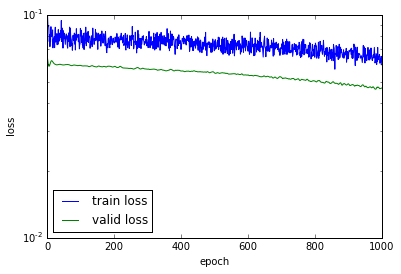

In [17]:
plot_loss(net49)

In [18]:
for i in range(5):
    X_test[:, i, :, :] = renormalize(X_test[:, i, :, :])
    
y_test = renormalize(y_test)

In [19]:
#Need to fix this since multioutput isn't working...
y_pred = net49.predict(X_test)
from sklearn.metrics import mean_absolute_error
y_abs_error = mean_absolute_error(y_test, y_pred) #, multioutput='raw values')
print(y_abs_error)

0.197672694067


ValueError: x has only one data point. bins or range kwarg must be given

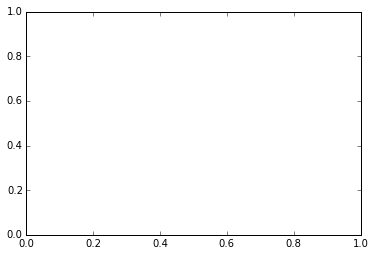

In [20]:
#MEAN ABSOLUTE ERROR, not currently operational.
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_abs_error, log=True)

In [21]:
# The closer to 0 this is, the better the prediction is!
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

0.0665514577281


In [22]:
# Best possible score = 1.0, can be negative (model can be arbitrarily worse)
# coefficient of determination 
# how well future samples are likely to be predicted by the model
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.138898249256


In [23]:
from sklearn.metrics import median_absolute_error
print(median_absolute_error(y_test, y_pred))

0.168136272284


In [24]:
np.save("net49_pred.npy", y_pred)